In [1]:
%matplotlib inline
# produce vector inline graphics
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'svg')

import re
import matplotlib.pyplot as plt
import numpy as np


def prepare_boxplot_data(filename, unable_to_reach_first_line = False):
    iperfString = read_file(filename)
    client_data = []
    server_data = []
    first_run_client = True

    iperf_output_list_initial = iperfString.split("iperf Done.")
    iperf_output_list_initial.pop()

    for entry in iperf_output_list_initial:
        server_client_list = entry.split("Server output:")

        for index, s_c_entry in enumerate(server_client_list):
            line_list = s_c_entry.split("\n")
            if(unable_to_reach_first_line): # If the first line of the file is that we're unable to reach the destination, then we remove that from the string
                line_list.pop(0)
                unable_to_reach_first_line = False
            
            if(index % 2 == 0):
                if(first_run_client):
                    del line_list[0:3]
                    first_run_client = False
                else:
                    del line_list[0:4]                
                del line_list[-6:-1]
                line_list.pop()
                for line in line_list:
                    if "Bytes" in line:
                        bitrate = find_between(line, "Bytes", "bits/sec").strip()
                        append_to_list(bitrate[:-1], client_data, bitrate[-1]) 
            else:
                del line_list[0:7]
                del line_list[-6:-1]
                line_list.pop()
                for line in line_list:
                    bitrate = find_between(line, "Bytes", "bits/sec").strip()
                    append_to_list(bitrate[:-1], server_data, bitrate[-1])

    return client_data, server_data


def scatter_plot_iperf_bitrate(path, y_label, x_label, x_axis_values, title, limits=[]):
    distance_iperf_files = path
    iperf_sender_results_list = []
    iperf_receiver_results_list = []

    for file in distance_iperf_files:
        iperfContent = read_file(file)
        iperf_output_list = split_iperf(iperfContent)
        iperf_list = extract_iperf(iperf_output_list)
        iperf_sender_list, iperf_receiver_list = [], []
        for index, entry in enumerate(iperf_list):
            if(index % 2 == 0):
                iperf_sender_list.append(entry)
            else:
                iperf_receiver_list.append(entry)

        iperf_sender_bitrate = [column[2] for column in iperf_sender_list]
        iperf_receiver_bitrate = [column[2] for column in iperf_receiver_list]
        iperf_sender_results_list.append(iperf_sender_bitrate)
        iperf_receiver_results_list.append(iperf_receiver_bitrate)

    #iperf_sender_results_list[6].append(0.0)
    x_axis = x_axis_values

    y_axis = []
    for entry in iperf_sender_results_list:
        y_axis = np.concatenate((y_axis, entry))

            
    for x_value, y_value in zip(x_axis, y_axis):
        plt.scatter(x=x_value, y=y_value, marker='o', color='blue')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    if(limits != []):
        plt.ylim(limits[1])
        plt.xlim(limits[0])
        
    plt.title(title)

# Reads and closes file before returning the content as a string
def read_file(fileName):
    file = open(fileName)
    fileContent = file.read()
    file.close()
    return fileContent

# Separates the inputted content into 4 lists of metrics (4 since we know that these metrics are always outputted)
def separate_metrics(fileString, ping_data = [], rss_data = [], route_data = [], link_data = []):
    fileString = remove_separations(fileString)
    # Split into lists of data
    ping_data = [] 
    rss_data = [] 
    route_data = [] 
    link_data = []
    for index, content in enumerate(fileString):
        if(index % 4 == 0):
            ping_data.append(content) 
        elif(index % 4 == 1):
            rss_data.append(content)
        elif(index % 4 == 2):
            route_data.append(content)
        elif(index % 4 == 3):
            link_data.append(content)

    return ping_data, rss_data, route_data, link_data

# Removes the redundant separations that are purely for visual assistance
def remove_separations(fileString):
    fileString = remove_occurrences(fileString, "----------------------------------------------------------------")
    fileString = remove_occurrences(fileString, "____________________________START_______________________________")
    fileString = remove_occurrences(fileString, "___________________________END__________________________________")
    fileString = remove_occurrences(fileString, "")
    return fileString

# Removes all occurences of a given item in a string
def remove_occurrences(fileString, item):
    res = [i for i in fileString if i != item]
    return res

# Extract packet loss, average rtt and the standard deviation of the rtt from the list of ping data
def read_ping_data(ping_data, packet_loss_list = [], avg_rtt_list = [], std_deviation_rtt = []):
    packet_loss_list = []
    avg_rtt_list = []
    std_deviation_rtt = []
    
    for entry in ping_data:
        ping_information = entry.split("---")[2]
        split_information = ping_information.split(",")
        if(split_information[2].split("%")[0].find("+7 errors") == 1):
            packet_loss_list.append('100')
        else:
            packet_loss_list.append(split_information[2].split("%")[0])
        try:
            avg_rtt_list.append(split_information[3].split("/")[4])
            std_deviation_rtt.append(split_information[3].split("/")[6][:-3])
        except:
            avg_rtt_list.append(np.nan)
            std_deviation_rtt.append(np.nan)
    return packet_loss_list, avg_rtt_list, std_deviation_rtt

# Extract RSS and average RSS from the list of RSS data
def read_rss_data(rss_data, rss_list = [], rss_avg_list = []):
    for entry in rss_data:
        rss_list.append(find_between(entry, "signal: ", "["))
        rss_avg_list.append(find_between(entry, "signal avg: ", "["))

    return rss_list, rss_avg_list

# Finds and returns the string between two given sequences of strings
def find_between(s, first, last, minusIndex = 0):
    start = s.index(first)+len(first)
    end = s.index(last, start)+minusIndex
    return s[start:end]

# Turns a list of strings into a list of floats
def list_string_to_float(stringList):
    floatList = [float(x) for x in stringList]
    return floatList

# Turns a list of strings into a list of floats
def list_string_to_int(stringList):
    intList = [int(x) for x in stringList]
    return intList

# Returns the average of a list
def list_average(list):
    return (sum(list) / len(list))


def split_iperf(iperfString):
    iperf_output_list = []
    iperf_output_list_initial = iperfString.split("iperf Done.")
    iperf_output_list_initial.pop()
    for entry in iperf_output_list_initial:
        server_client_list = entry.split("Server output:")
        server_client_edited_list = []
        str_to_find = "- - - - - - - - - - - - - - - - - - - - - - - - -"
        for s_c_entry in server_client_list:
            s_c_entry = s_c_entry[s_c_entry.find(str_to_find)+len(str_to_find)+1:]
            server_client_edited_list.append(s_c_entry)
        iperf_output_list.append(server_client_edited_list)

    return iperf_output_list

def append_to_list(value, list, unit):
    if(unit == 'M' or unit == 'm'):
        list.append(float(value)*1000*1000)
    elif(unit == 'K' or unit == 'k'):
        list.append(float(value)*1000)
    else:
        list.append(float(value))
    return
    
# Extracts iperf into a list of lists in the following format:
# Index 0 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# Index 1 (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
# Index 2 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# ...
# Index n (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
def extract_iperf(iperf_list):
    s_c_entry_list = []
    for s_c_entry in iperf_list:
        entry_list = []
        for entry in s_c_entry:
            entry_list = []
            time_taken = find_between(entry, "-", "sec").strip()
            entry_list.append(time_taken)
            
            bits_transferred = find_between(entry, "sec", "Bytes").strip()
            append_to_list(bits_transferred[:-1], entry_list, bits_transferred[-1])

            try:
                try:
                    transfer_rate = find_between(entry, "MBytes", "bits/sec").strip()
                    append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
                except:
                    transfer_rate = find_between(entry, "KBytes", "bits/sec").strip()
                    append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
            except:
                transfer_rate = find_between(entry, " Bytes", "bits/sec").strip()
                append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
            if "Retr" in entry:
                retry_number = find_between(entry, "/sec", "sender").strip()
                entry_list.append(retry_number)
            s_c_entry_list.append(entry_list)
    return s_c_entry_list



def read_station_dump(rss_data):
    mac_list = []
    signal_list = []
    rss_list = []
    rss_avg_list = []
    rss_list_sorted = []
    rss_dict = {}
    rss_avg_list_sorted = []

    for entry in rss_data:
       mac_list.append(re.findall(r'(?:[0-9a-fA-F]:?){12}',entry, re.ASCII))
       signal_list.append(re.findall(r'\[.*?\]',entry))
      
    for entry in signal_list:
        temp_list = []
        temp_list = [s.strip("[]") for s in entry]
        temp_list = list(map(int, temp_list))
        rss_list.append(temp_list)
       
    for i, entry in enumerate(rss_list):
        temp_list = []
        for j, content in enumerate(entry):
            if(j % 2 == 1):
                temp_list.append(content)
                rss_list[i][j] = 0
        rss_avg_list.append(temp_list)
        entry = [i for i in entry if i != 0]
        rss_list[i] = entry

    rss_dict = dict.fromkeys(mac_list[0])

    if(len(rss_dict.keys()) == 2):
        for i in range(2):
            try:
                rss_list_sorted.append([entry[i] for entry in rss_list])
                rss_avg_list_sorted.append([entry[i] for entry in rss_avg_list])
            except:
                rss_list_sorted.append(np.nan)
                rss_avg_list_sorted.append(np.nan)
                
    elif(len(rss_dict.keys()) == 3):
         for i in range(3):
            rss_list_sorted.append([entry[i] for entry in rss_list])
            rss_avg_list_sorted.append([entry[i] for entry in rss_avg_list])
    else:
            rss_list_sorted.append([entry[0] for entry in rss_list])
            rss_avg_list_sorted.append([entry[0] for entry in rss_avg_list])


    for i, mac_addr in enumerate(mac_list[0]):
        try:
            calculated_raw_avg = sum(rss_list_sorted[i]) / len(rss_list_sorted[i])
            calculated_avg_of_avg = sum(rss_avg_list_sorted[i]) / len(rss_avg_list_sorted[i])
        except:
            calculated_raw_avg = np.nan
            calculated_avg_of_avg = np.nan
        rss_dict[mac_addr] = (calculated_raw_avg, calculated_avg_of_avg)

    
    #Hvis dbm signalet ikke findes for en mac adresse sættes dette til NaN    
      
    return rss_dict

def converted_ping_data(path, data_value):
    file_path = path
    data = []
    raw_data = []
    converted_data = []
    
    if(type(file_path) != list):
        file_content = read_file(file_path)
        split_content = file_content.split("\n")
        raw_data.append(separate_metrics(split_content)[0])
    else:
        for file in file_path:
            file_content = read_file(file)
            split_content = file_content.split("\n")
            raw_data.append(separate_metrics(split_content)[0])

    for entry in raw_data:
        if(data_value == 'packet_loss'):
            data.append(read_ping_data(entry)[0])
        elif(data_value == 'avg_rtt'):
            data.append(read_ping_data(entry)[1])
        elif(data_value == 'std_deviation'):
            data.append(read_ping_data(entry)[2])
    if(data_value == 'packet_loss'):
        converted_data = [[int(x) for x in lst] for lst in data]
    elif(data_value == 'avg_rtt'):
        converted_data = [[float(x) for x in lst] for lst in data]
    elif(data_value == 'std_deviation'):
        converted_data = [[float(x) for x in lst] for lst in data]
    return converted_data

In [2]:
import itertools
def separate_link_metrics(path, flag):
    unsorted_data = []
    sorted_data = []
    mcs2_rx = []
    mcs2_tx = []
    mcs4_rx = []
    mcs4_tx = []
    unsorted_mac = []

    mac_dict_mcs2 = {}
    mac_dict_mcs4 = {}
    
    for file in path:
        separated_metrics = []
        file_content = read_file(file)
        split_content = file_content.split("\n")
        separated_metrics = separate_metrics(split_content)[3]
        unsorted_data.append(separated_metrics)

    for entry in unsorted_data:
        for item in entry:
            unsorted_mac.append(re.findall(r'(?:[0-9a-fA-F]:?){12}',item, re.ASCII))
    
    mac_dict_mcs2 = dict.fromkeys(unsorted_mac[0])
    mac_dict_mcs4 = dict.fromkeys(unsorted_mac[0])
    for i, entry in enumerate(unsorted_data):
        temp_data = []
        for item in entry:
            temp_data.append(re.sub(r'(?:[0-9a-fA-F]:?){12}',' ',item, re.ASCII))
        unsorted_data[i] = temp_data    
    
    for i, entry in enumerate(unsorted_data):
        temp_data = []
        for item in entry:
            temp_data.append(item.split("     "))
        unsorted_data[i] = temp_data    

    for entry in unsorted_data:
        for item in entry:
            del item[0]
            
    for i, entry in enumerate(unsorted_data):
        temp_data = []
        for item in entry:
            item = [x.split(':')[1] for x in item]
            item = [x.replace('/',' ') for x in item]
            
            temp_data.append(item)
        unsorted_data[i] = temp_data

    for i, entry in enumerate(unsorted_data):
        temp_data = []
        for item in entry:
            item = [x.split('%') for x in item]
            
            temp_data.append(item)
            
        unsorted_data[i] = temp_data

    temp_sorted_data = list(itertools.chain(*unsorted_data))
    sorted_data = list(itertools.chain(*temp_sorted_data))
    
    for entry in sorted_data:
        del entry[-1]

    print(len(sorted_data))
    if(flag == "Interference_1"):
        sorted_data.insert(10,['0', '0', '0', '0', '0', '0'])
    elif(flag == "Interference_2"):
        sorted_data.insert(10,['0', '0', '0', '0', '0', '0'])
        sorted_data.insert(52,['0', '0', '0', '0', '0', '0'])
    elif(flag == "Distance"):
        print(len(sorted_data))
    
    for entry in sorted_data:
        #print(entry)
        for i, item in enumerate(entry):
            if(i % 6 == 0):
                mcs2_rx.append(item)
            elif(i % 6 == 1):
                mcs2_tx.append(item)
            elif(i % 6 == 2):
                mcs4_rx.append(item)
            elif(i % 6 == 3):
                mcs4_tx.append(item)
    
    for key in mac_dict_mcs2:
        mac_dict_mcs2[key] = []
        mac_dict_mcs4[key] = []
    
    mac_keys = list(mac_dict_mcs2)

    for i in range(len(mcs2_rx)):
        if(i % 3 == 0):
            mac_dict_mcs2[mac_keys[0]].append((mcs2_rx[i],mcs2_tx[i]))
            mac_dict_mcs4[mac_keys[0]].append((mcs4_rx[i],mcs4_tx[i]))
        elif(i % 3 == 1):
            mac_dict_mcs2[mac_keys[1]].append((mcs2_rx[i],mcs2_tx[i]))
            mac_dict_mcs4[mac_keys[1]].append((mcs4_rx[i],mcs4_tx[i]))
        elif(i % 3 == 2):
            mac_dict_mcs2[mac_keys[2]].append((mcs2_rx[i],mcs2_tx[i]))
            mac_dict_mcs4[mac_keys[2]].append((mcs4_rx[i],mcs4_tx[i]))
    return (mac_dict_mcs2, mac_dict_mcs4)

In [3]:
def get_avg_link(mcs2,mcs4):
    mcs2_dict = dict.fromkeys(mcs2)
    mcs4_dict = dict.fromkeys(mcs4)
    mac_keys = list(mcs2_dict)
    
    mcs2_data = []
    mcs4_data = []
    

    for key in mac_keys:
        mcs2_data = mcs2[key]
        mcs2_avg = []

        mcs4_data = mcs4[key]
        mcs4_avg = []
        rx_data = []
        tx_data = []
        
        for entry in mcs2_data:
            rx_data.append(entry[0])
            tx_data.append(entry[1])

        for i in range(0, len(tx_data),15):
    
            converted_rx_values = list(map(int, rx_data[i:i+15]))
            converted_tx_values = list(map(int, tx_data[i:i+15]))
            temp_rx_avg = sum(converted_rx_values)/len(rx_data[i:i+15])
            temp_tx_avg = sum(converted_tx_values)/len(tx_data[i:i+15])
            mcs2_avg.append((temp_rx_avg,temp_tx_avg))
        
        mcs2_dict[key] = mcs2_avg

        rx_data.clear()
        tx_data.clear()

        for entry in mcs4_data:
            rx_data.append(entry[0])
            tx_data.append(entry[1])

        for i in range(0, len(tx_data),15):
            
            converted_rx_values = list(map(int, rx_data[i:i+15]))
            converted_tx_values = list(map(int, tx_data[i:i+15]))
            temp_rx_avg = sum(converted_rx_values)/len(rx_data[i:i+15])
            temp_tx_avg = sum(converted_tx_values)/len(tx_data[i:i+15])
            mcs4_avg.append((temp_rx_avg,temp_tx_avg))
        
        mcs4_dict[key] = mcs4_avg
    
    return(mcs2_dict, mcs4_dict)


In [54]:
def plot_link_metrics(mcs2, mcs4, mac_address, x_axis, x_label = "Gain of interference source [dB]", title = "RX/TX Link quality of"):
    keys = ['MCS2-RX', 'MCS2-TX', 'MCS4-RX', 'MCS4-TX']
    markers = ['o','s','x','v']
    data_dict = dict.fromkeys(keys)

    for key in data_dict:
        data_dict[key] = []
    
    for entry in mcs2:
        data_dict[keys[0]].append(entry[0])
        data_dict[keys[1]].append(entry[1])
        
    for entry in mcs4:
        data_dict[keys[2]].append(entry[0])
        data_dict[keys[3]].append(entry[1])

    marker_pos = 0
    for key, value in data_dict.items():
        plt.plot(x_axis, value, label=key, marker=markers[marker_pos])
        marker_pos += 1

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=True)
    plt.ylabel("Link Quality [%]")
    plt.xlabel(x_label)
    plt.title(title + " " + mac_address)
    plt.show()
    

    
    


269


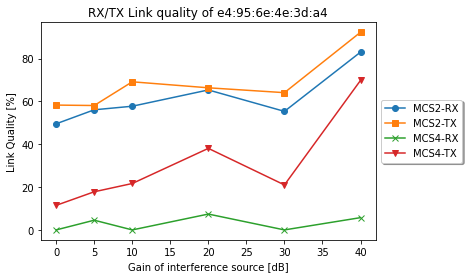

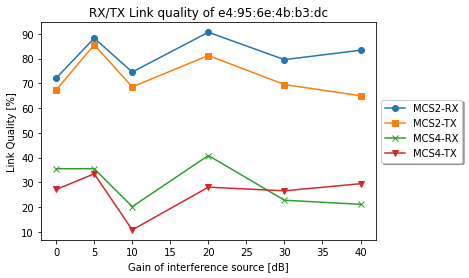

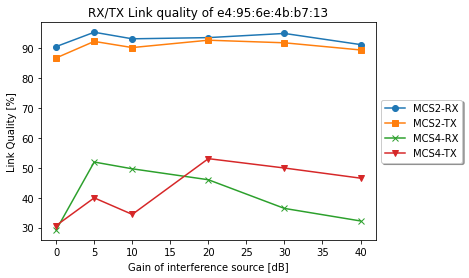

In [55]:
distance_interference_file_iperf = "../Mesh Configuration/Interference_1/Dongle/results_"
distance_interference_iperf_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        distance_interference_file_iperf + "5G.txt",
                        distance_interference_file_iperf + "10G.txt",
                        distance_interference_file_iperf + "20G.txt",
                        distance_interference_file_iperf + "30G.txt",
                        distance_interference_file_iperf + "40G.txt",
                        ]
mcs2_link_data, mcs4_link_data = separate_link_metrics(distance_interference_iperf_files,"Interference_1")

mcs2_avg, mcs4_avg = get_avg_link(mcs2_link_data,mcs4_link_data)

x_axis = np.array([0,5,10,20,30,40])

for key in mcs2_avg:
    plot_link_metrics(mcs2_avg[key],
    mcs4_avg[key],
    key,x_axis)


268


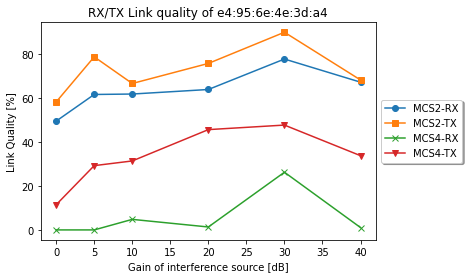

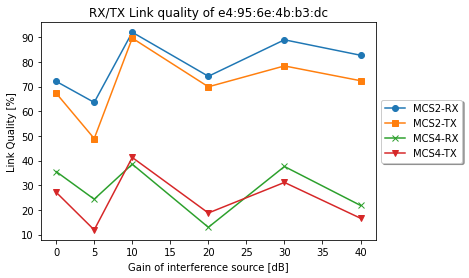

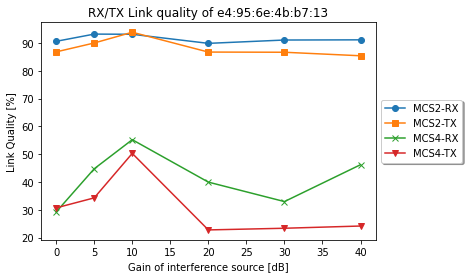

In [56]:
distance_interference_file_iperf = "../Mesh Configuration/Interference_2/Dongle/results_"
distance_interference_iperf_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        distance_interference_file_iperf + "5G.txt",
                        distance_interference_file_iperf + "10G.txt",
                        distance_interference_file_iperf + "20G.txt",
                        distance_interference_file_iperf + "30G.txt",
                        distance_interference_file_iperf + "40G.txt",
                        ]
mcs2_link_data, mcs4_link_data = separate_link_metrics(distance_interference_iperf_files,"Interference_2")

mcs2_avg, mcs4_avg = get_avg_link(mcs2_link_data,mcs4_link_data)

x_axis = np.array([0,5,10,20,30,40])

for key in mcs2_avg:
    plot_link_metrics(mcs2_avg[key],
    mcs4_avg[key],
    key,x_axis)

In [35]:
#def plot_rss(path, data_value, y_label, x_label, x_axis_values, title):
def plot_rss(path, title, x_axis, x_label = 'Distance [m]', x_limit = (0,145)):
    unsorted_data = []
    extracted_rss = []
    extracted_raw_avg = {}
    extracted_avg_of_avg = {}
    for file in path:
        separated_metrics = []
        file_content = read_file(file)
        split_content = file_content.split("\n")
        separated_metrics = separate_metrics(split_content)[1]
        unsorted_data.append(separated_metrics)
    
    for entry in unsorted_data:
        extracted_rss.append(read_station_dump(entry))
    
    extracted_raw_avg = {}
    extracted_avg_of_avg = {}
    for key in extracted_rss[0].keys():
        extracted_raw_avg[key] = []
        extracted_avg_of_avg[key] = []
        
    for entry in extracted_rss:
        for key, value in entry.items():
            extracted_raw_avg[key].append(value[0])
            extracted_avg_of_avg[key].append(value[1])
    
    markers = ['o','s','x']
    colors = ['#1f77b4','#ff7f0e','#2ca02c']
    marker_pos = 0
    color_pos = 0
    for key, value in extracted_raw_avg.items():
        print(value)
        plt.plot(x_axis, value,color=colors[color_pos], label=key,marker=markers[marker_pos])
        color_pos += 1
        marker_pos += 1
            
    
    plt.legend()
    plt.ylabel("RSS [dBm]")
    plt.xlabel(x_label)
    plt.xlim(x_limit[0],x_limit[1])
    plt.ylim(-90,-50)
    plt.title(title)
    
    
    #print(extracted_avg_of_avg)
    #print(extracted_raw_avg)
    #x_axis = list(range(1,len(iperf_sender_bytes)+1)) 
    #print(extracted_rss)

In [ ]:
def packet_loss_cumsum(path):
    ping_data = converted_ping_data(path, 'packet_loss')
    cumulative_sum = []
    max_values = []
    
    for entry in ping_data:
        cumulative_sum.append(np.cumsum(entry).tolist())

    for entry in cumulative_sum:
        
        max_values.append(max(entry))
    
    return max_values
    

In [ ]:
####### BAR PLOT - DISTANCE PACKET LOSS ######
distance_file_result = "../Distance/Dongle/single-hop/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
distance_file_result_int = "../Distance/Dongle/single-hop_interference/results_"
distance_result_files_int = [
                        distance_file_result_int + "10m.txt",
                        distance_file_result_int + "20m.txt",
                        distance_file_result_int + "30m.txt",
                        distance_file_result_int + "40m.txt",
                        distance_file_result_int + "50m.txt",
                        distance_file_result_int + "60m.txt",
                        distance_file_result_int + "70m.txt",
                        distance_file_result_int + "80m.txt",
                        distance_file_result_int + "90m.txt",
                        distance_file_result_int + "100m.txt"
                        ]

x = np.array([10,20,30,40,50,60,70,80,90,100])
y1 = packet_loss_cumsum(distance_result_files)
y2 = packet_loss_cumsum(distance_result_files_int)
width = 3

print(y1)
print(y2)

plt.bar(x-(0.5*width), y1, width, edgecolor = 'black')
plt.bar(x+(0.5*width), y2, width, edgecolor = 'black')
plt.legend(["No Interference", "Interference"])
plt.xlabel("Distance between source and destination [m]")
plt.ylabel("Cumulative sum of packet loss")
plt.xlim((5, 145))
plt.ylim((0,1500))
plt.show()

In [ ]:
distance_file_result = "../Distance/Dongle/Multi-hop/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
distance_file_result_int = "../Distance/Dongle/Multi-hop_interference/results_"
distance_result_files_int = [
                        distance_file_result_int + "10m.txt",
                        distance_file_result_int + "20m.txt",
                        distance_file_result_int + "30m.txt",
                        distance_file_result_int + "40m.txt",
                        distance_file_result_int + "50m.txt",
                        distance_file_result_int + "60m.txt",
                        distance_file_result_int + "70m.txt",
                        distance_file_result_int + "80m.txt",
                        distance_file_result_int + "90m.txt",
                        distance_file_result_int + "100m.txt"
                        ]
x = np.array([50,60,70,80,90,100,110,120,130,140])
y1 = packet_loss_cumsum(distance_result_files)
y2 = packet_loss_cumsum(distance_result_files_int)

print(y1)
print(y2)
width = 3

plt.bar(x-(0.5*width), y1, width, edgecolor = 'black')
plt.bar(x+(0.5*width), y2, width, edgecolor = 'black')
plt.xlim((5,145))
plt.ylim((0,1500))
plt.legend(["No Interference", "Interference"])
plt.xlabel("Distance between source and destination [m]")
plt.ylabel("Cumulative sum of packet loss")
plt.show()

In [ ]:
transmission_power_path = "../Transmission Power/Dongle/Single-hop/results_"
transmission_power_no_int_files = [
                        transmission_power_path + "10TX.txt",
                        # transmission_power_path + "11TX.txt",
                        transmission_power_path + "12TX.txt",
                        # transmission_power_path + "13TX.txt",
                        transmission_power_path + "14TX.txt",
                        # transmission_power_path + "15TX.txt",
                        transmission_power_path + "16TX.txt",
                        # transmission_power_path + "17TX.txt",
                        transmission_power_path + "18TX.txt",
                        # transmission_power_path + "19TX.txt",
                        transmission_power_path + "20TX.txt",
                        ]
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/results_"
transmission_power_int_files = [
                        transmission_power_int_path + "10TX.txt",
                        transmission_power_int_path + "12TX.txt",
                        transmission_power_int_path + "14TX.txt",
                        transmission_power_int_path + "16TX.txt",
                        transmission_power_int_path + "18TX.txt",
                        transmission_power_int_path + "20TX.txt",
                        ]
x = np.array([10,12,14,16,18,20])
y1 = packet_loss_cumsum(transmission_power_no_int_files)
y2 = packet_loss_cumsum(transmission_power_int_files)
width = 3
print(y1)
print(y2)
plt.bar(x-(0.5*width), y1, width, edgecolor = 'black')
plt.bar(x+(0.5*width), y2, width, edgecolor = 'black')
plt.legend(["No Interference", "Interference"])
plt.xlabel("Transmission power [dBm]")
plt.ylabel("Cumulative sum of packet loss")
plt.ylim(0,20)
plt.show()

In [ ]:
####### BAR PLOT - MESH CONFIGURATION PACKET LOSS ######
distance_interference1_file_iperf = "../Mesh Configuration/Interference_1/Dongle/results_"
distance_interference1_iperf_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        distance_interference1_file_iperf + "5G.txt",
                        distance_interference1_file_iperf + "10G.txt",
                        distance_interference1_file_iperf + "20G.txt",
                        distance_interference1_file_iperf + "30G.txt",
                        distance_interference1_file_iperf + "40G.txt",
                        ]
distance_interference2_file_iperf = "../Mesh Configuration/Interference_2/Dongle/results_"
distance_interference2_iperf_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        distance_interference2_file_iperf + "5G.txt",
                        distance_interference2_file_iperf + "10G.txt",
                        distance_interference2_file_iperf + "20G.txt",
                        distance_interference2_file_iperf + "30G.txt",
                        distance_interference2_file_iperf + "40G.txt",
                        ]

x = np.array([0,5,10,20,30,40])
y1 = packet_loss_cumsum(distance_interference1_iperf_files)
y2 = packet_loss_cumsum(distance_interference2_iperf_files)
print(y1)
print(y2)
width = 2
plt.bar(x-(0.5*width), y1, width, edgecolor = 'black')
plt.bar(x+(0.5*width), y2, width, edgecolor = 'black')
plt.legend(["Interference at one node", "Interference at two nodes"])
plt.xlim(-5,45)
plt.xticks(x)
plt.xlabel("Gain of interference source [dB]")
plt.ylabel("Cumulative sum of packet loss")
plt.show()

In [ ]:
distance_interference_file_iperf = "../Mesh Configuration/Interference_2/Dongle/results_"
distance_interference_iperf_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        distance_interference_file_iperf + "5G.txt",
                        distance_interference_file_iperf + "10G.txt",
                        distance_interference_file_iperf + "20G.txt",
                        distance_interference_file_iperf + "30G.txt",
                        distance_interference_file_iperf + "40G.txt",
                        ]

x = np.array([0,5,10,20,30,40])
y = packet_loss_cumsum(distance_interference_iperf_files)
width = 3
plt.bar(x, y, width, edgecolor = 'black')
plt.xlabel("Gain of interference Source [dB]")
plt.ylabel("Cumulative sum of packet loss")
plt.show()

[-57.4, -57.06666666666667, -64.0, -65.46666666666667, -69.6, -71.26666666666667, -74.13333333333334, -74.66666666666667, -78.8, -78.6]


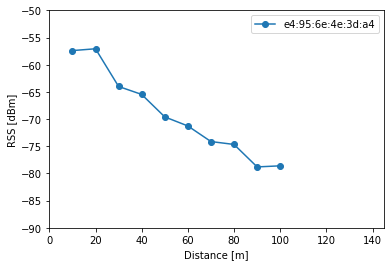

In [36]:
distance_file_result = "../Distance/Dongle/single-hop/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
x_axis = [10,20,30,40,50,60,70,80,90,100]
plot_rss(distance_result_files,"", x_axis)

[-67.2, -65.33333333333333, -61.266666666666666, -72.4, -67.13333333333334, -70.66666666666667, -74.0, -73.4, -75.46666666666667, -78.06666666666666]


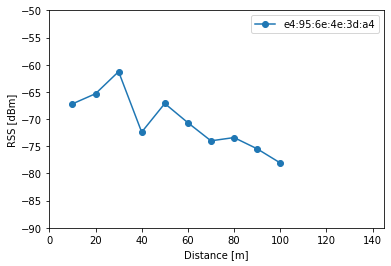

In [37]:
distance_file_result = "../Distance/Dongle/single-hop_interference/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
x_axis = [10,20,30,40,50,60,70,80,90,100]
plot_rss(distance_result_files,"", x_axis)

[-72.26666666666667, -72.06666666666666, -70.66666666666667, -69.33333333333333, -68.93333333333334, -67.8, -66.86666666666666, -65.66666666666667, -66.8, -63.333333333333336, -65.13333333333334]


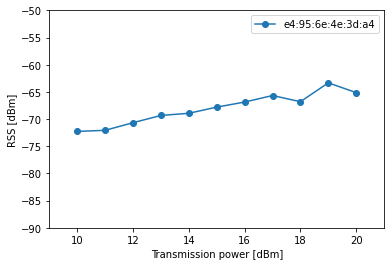

In [38]:
transmission_power_path = "../Transmission Power/Dongle/Single-hop/results_"
transmission_power_no_int_files = [
                        transmission_power_path + "10TX.txt",
                        transmission_power_path + "11TX.txt",
                        transmission_power_path + "12TX.txt",
                        transmission_power_path + "13TX.txt",
                        transmission_power_path + "14TX.txt",
                        transmission_power_path + "15TX.txt",
                        transmission_power_path + "16TX.txt",
                        transmission_power_path + "17TX.txt",
                        transmission_power_path + "18TX.txt",
                        transmission_power_path + "19TX.txt",
                        transmission_power_path + "20TX.txt",
                        ]
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/results_"

x_axis = [10,11,12,13,14,15,16,17,18,19,20]
plot_rss(transmission_power_no_int_files,"", x_axis,'Transmission power [dBm]', x_limit=(9,21))

[-73.06666666666666, -71.33333333333333, -70.86666666666666, -67.66666666666667, -67.0, -65.26666666666667]


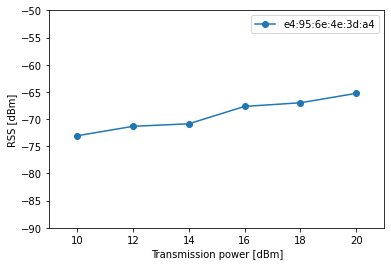

In [39]:
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/results_"
transmission_power_int_files = [
                        transmission_power_int_path + "10TX.txt",
                        transmission_power_int_path + "12TX.txt",
                        transmission_power_int_path + "14TX.txt",
                        transmission_power_int_path + "16TX.txt",
                        transmission_power_int_path + "18TX.txt",
                        transmission_power_int_path + "20TX.txt",
                        ]
x_axis = [10,12,14,16,18,20]
plot_rss(transmission_power_int_files,"", x_axis,'Transmission power [dBm]', x_limit=(9,21))

[-65.93333333333334, -67.93333333333334, -76.6, -72.0, -65.8, -69.6, -68.13333333333334, -67.2, -68.86666666666666, -68.4]
[-67.73333333333333, -71.46666666666667, -77.73333333333333, -76.6, -80.66666666666667, -79.6, -78.93333333333334, -81.73333333333333, -82.26666666666667, nan]


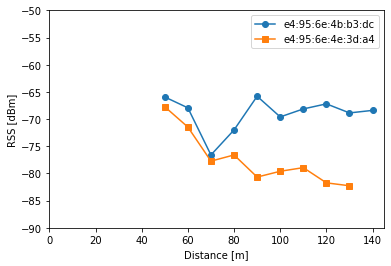

In [40]:
distance_file_result = "../Distance/Dongle/Multi-hop/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
x_axis = [50,60,70,80,90,100,110,120,130,140]
plot_rss(distance_result_files,"", x_axis)

[-75.93333333333334, -68.86666666666666, -72.06666666666666, -71.8, -67.8, -70.6, -71.13333333333334, -71.46666666666667, -71.53333333333333, -70.06666666666666]
[-69.4, -73.26666666666667, -76.06666666666666, -75.86666666666666, -77.06666666666666, -78.26666666666667, -80.26666666666667, -79.8, -83.4, -83.93333333333334]


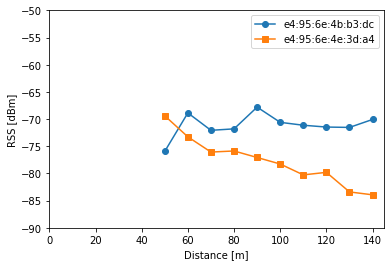

In [41]:
distance_file_result = "../Distance/Dongle/Multi-hop_interference/results_"
distance_result_files = [
                        distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
x_axis = [50,60,70,80,90,100,110,120,130,140]
plot_rss(distance_result_files,"", x_axis)

10m: 
1.3730769230769229
20m: 
1.1235632183908046
30m: 
1.028692380056444
40m: 
5.049019607843137
50m: 
1.6499339498018495
60m: 
1.2424373379429559
70m: 
1.040021063717746
80m: 
1.6241883116883116
90m: 
0.09937688994776872
100m: 
0.830070575326068


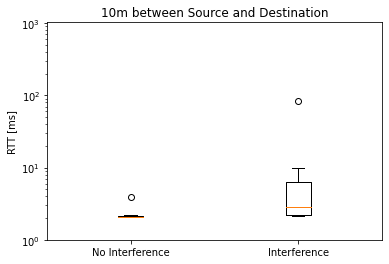

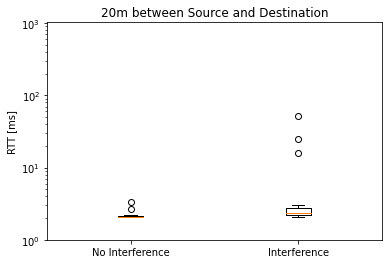

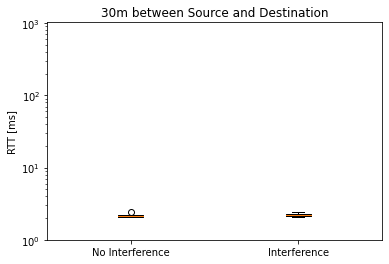

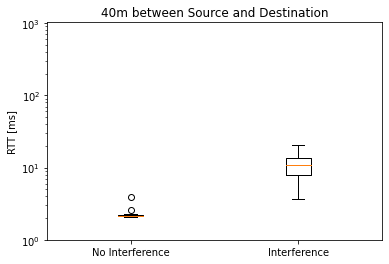

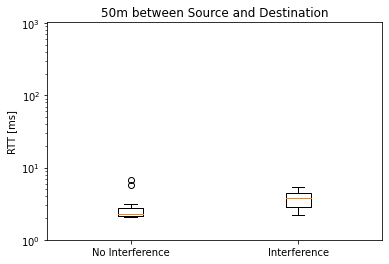

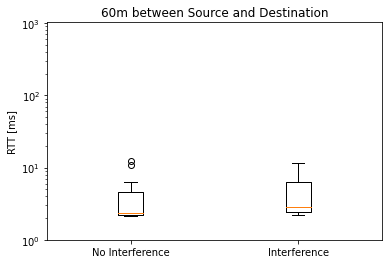

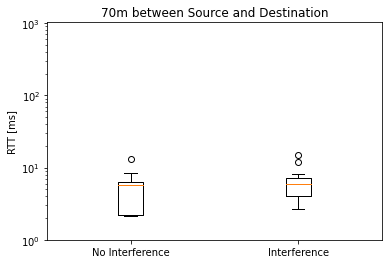

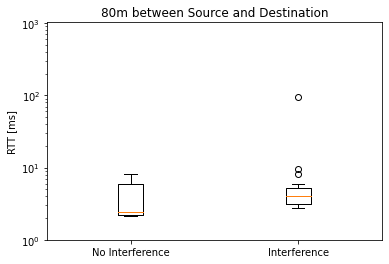

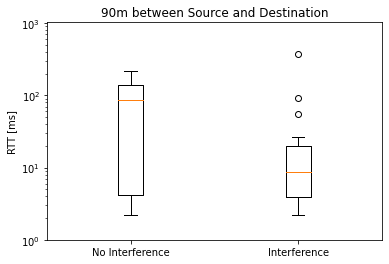

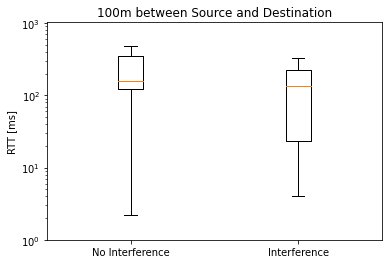

In [42]:
import statistics

distance_result = "../Distance/Dongle/single-hop/results_"
distance_result_files = [distance_result + "10m.txt",
                        distance_result + "20m.txt",
                        distance_result + "30m.txt",
                        distance_result + "40m.txt",
                        distance_result + "50m.txt",
                        distance_result + "60m.txt",
                        distance_result + "70m.txt",
                        distance_result + "80m.txt",
                        distance_result + "90m.txt",
                        distance_result + "100m.txt"
                        ]

distance_interference_result = "../Distance/Dongle/single-hop_interference/results_"
distance_interference_result_files = [distance_interference_result + "10m.txt",
                                    distance_interference_result + "20m.txt",
                                    distance_interference_result + "30m.txt",
                                    distance_interference_result + "40m.txt",
                                    distance_interference_result + "50m.txt",
                                    distance_interference_result + "60m.txt",
                                    distance_interference_result + "70m.txt",
                                    distance_interference_result + "80m.txt",
                                    distance_interference_result + "90m.txt",
                                    distance_interference_result + "100m.txt"
                                    ]

boxplot_titles = ['10m','20m','30m','40m','50m','60m','70m','80m','90m','100m']

for filename, filename_int, title in zip(distance_result_files, distance_interference_result_files, boxplot_titles):
    avg_rtt = converted_ping_data(filename,"avg_rtt")
    avg_rtt_interference = converted_ping_data(filename_int,"avg_rtt")
    data_dict = {'No Interference': avg_rtt[0], 'Interference': avg_rtt_interference[0]}
    fig, ax = plt.subplots()
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_yscale('log')
    #ax.set_ylim(-50, 500)
    ax.set_ylim([1,2**10])
    ax.set_ylabel('RTT [ms]')
    print(title + ": ")
    print((statistics.median(avg_rtt_interference[0])/statistics.median(avg_rtt[0])))
    
    ax.set_title(title + ' between Source and Destination')




In [ ]:
distance_file_result = "../Distance/Dongle/multi-hop/results_"
distance_result_files = [distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
                        
y_label = "Packet Loss [%]"
x_label = "Distance between source and destination [m]"
title = "Single-hop without interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

#scatter_plot_packet_loss(distance_result_files,'packet_loss',y_label,x_label,x_axis,title)

In [ ]:
content = read_file("../Mesh Configuration/Interference_2/Dongle/results_5G.txt")
split_content = content.split("\n")
ping_data, rss_data, route_data, link_data = separate_metrics(split_content)
#packet_loss_list, avg_rtt_list, std_deviation_rtt = read_ping_data(ping_data)
#rss_list, rss_avg_list = read_rss_data(rss_data)
rss_values = read_station_dump(rss_data)
print(link_data)
packet_loss = converted_ping_data(["../Distance/Dongle/multi-hop/results_100m.txt"],"packet_loss")
#iperfContent = read_file("../Dongle/iperf_results.txt")
#iperf_output_list = split_iperf(iperfContent)
#iperf_list = extract_iperf(iperf_output_list)
#hello = 1
#print(mac_list)
#print(rss_list)
#print(rss_avg_list)
# TODO: Still missing extraction of LINK and ROUTE metrics 
# I am not sure what is important in these measurements, so figure this out. In route the routing metric is probably important/interesting to look at
#
# Answer: Routing protocol metric might be interesting to look at. The stale metric from Link. And the p metric from route.


# TODO: How should we do the plotting of different experiments within one experiment? 
# Should we just average the measurements across the list of data measurements from each experiment and then plot these averages against each other?
#
# Answer: Attempt to use the full range of measurements across one experiment and then color code according to experiment.

In [ ]:
# import matplotlib.pyplot as plt

# # ######### Prepare lists by turning them into floats/ints instead of strings######
# # # Int
# # rss_list = list_string_to_int(rss_list)
# # rss_avg_list = list_string_to_int(rss_avg_list)
# iperf_sender_list = [column[1] for column in iperf_list]
# iperf_receiver_list = [column[2] for column in iperf_list]
# iperf_sender_bytes = list_string_to_float(iperf_sender_list)
# iperf_receiver_bytes = list_string_to_float(iperf_receiver_list)

# # # Float
# # avg_rtt_list = list_string_to_float(avg_rtt_list)
# # std_deviation_rtt = list_string_to_float(std_deviation_rtt)
# # packet_loss_list = list_string_to_float(packet_loss_list)
# # #################################################################################

# # # Example of plotting
# # x_axis = list(range(1, len(rss_avg_list)+1))
# # fig_avg_rss, axis_avg_rss = plt.subplots()
# # axis_avg_rss.plot(x_axis, rss_avg_list)
# # axis_avg_rss.set_title("Average of RSS")
# # axis_avg_rss.set_xlabel("Sample number")
# # axis_avg_rss.set_ylabel("Average RSS value")
# x_axis = list(range(1,len(iperf_sender_bytes)+1))
# fig_iperf, axis_iperf = plt.subplots()
# axis_iperf.plot(x_axis, iperf_sender_bytes)
# axis_iperf.plot(x_axis, iperf_receiver_bytes)

In [ ]:
distance_file_result = "../Distance/Dongle/Single-hop_interference/results_"
distance_result_files = [distance_file_result + "10m.txt",
                        distance_file_result + "20m.txt",
                        distance_file_result + "30m.txt",
                        distance_file_result + "40m.txt",
                        distance_file_result + "50m.txt",
                        distance_file_result + "60m.txt",
                        distance_file_result + "70m.txt",
                        distance_file_result + "80m.txt",
                        distance_file_result + "90m.txt",
                        distance_file_result + "100m.txt"
                        ]
#print(distance_result_files)
y_label = "Packet Loss [%]"
x_label = "Distance between source and destination [m]"
title = "Single-hop with interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

#scatter_plot_packet_loss(distance_result_files,'packet_loss',y_label,x_label,x_axis,title)

In [ ]:
############# DISTANCE EXPERIMENT - Single-hop #####################
distance_file_iperf = "../Distance/Dongle/Single-hop/iperf_results_"
distance_iperf_files = [distance_file_iperf + "10m.txt",
                        distance_file_iperf + "20m.txt",
                        distance_file_iperf + "30m.txt",
                        distance_file_iperf + "40m.txt",
                        distance_file_iperf + "50m.txt",
                        distance_file_iperf + "60m.txt",
                        distance_file_iperf + "70m.txt",
                        distance_file_iperf + "80m.txt",
                        distance_file_iperf + "90m.txt",
                        distance_file_iperf + "100m.txt"
                        ]
print(distance_iperf_files)
y_label = "Throughput [bits/sec]"
x_label = "Distance between source and destination [m]"
title = "Single-hop without interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

limits = [(5, 145), (0, 9000000)]


scatter_plot_iperf_bitrate(distance_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
############# DISTANCE EXPERIMENT Single-hop interference #####################
distance_interference_file_iperf = "../Distance/Dongle/Single-hop_interference/iperf_results_"
distance_interference_iperf_files = [distance_interference_file_iperf + "10m.txt",
                        distance_interference_file_iperf + "20m.txt",
                        distance_interference_file_iperf + "30m.txt",
                        distance_interference_file_iperf + "40m.txt",
                        distance_interference_file_iperf + "50m.txt",
                        distance_interference_file_iperf + "60m.txt",
                        distance_interference_file_iperf + "70m.txt",
                        distance_interference_file_iperf + "80m.txt",
                        distance_interference_file_iperf + "90m.txt",
                        distance_interference_file_iperf + "100m.txt"
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Distance between source and destination [m]"
title = "Single-hop with interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

limits = [(5, 145), (0, 9000000)]


scatter_plot_iperf_bitrate(distance_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
filenames = ["../Distance/Dongle/Single-hop/iperf_results_10m.txt", 
            "../Distance/Dongle/Single-hop/iperf_results_20m.txt", 
            "../Distance/Dongle/Single-hop/iperf_results_30m.txt", 
            "../Distance/Dongle/Single-hop/iperf_results_40m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_50m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_60m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_70m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_80m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_90m.txt",
            "../Distance/Dongle/Single-hop/iperf_results_100m.txt"]
filenames_interference = ["../Distance/Dongle/Single-hop_interference/iperf_results_10m.txt", 
                        "../Distance/Dongle/Single-hop_interference/iperf_results_20m.txt", 
                        "../Distance/Dongle/Single-hop_interference/iperf_results_30m.txt", 
                        "../Distance/Dongle/Single-hop_interference/iperf_results_40m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_50m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_60m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_70m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_80m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_90m.txt",
                        "../Distance/Dongle/Single-hop_interference/iperf_results_100m.txt"]
boxplot_titles = ['10m', '20m', '30m', '40m', '50m', '60m', '70m', '80m', '90m', '100m']
            

for filename, filename_int, title in zip(filenames, filenames_interference, boxplot_titles):
    client_data, server_data = prepare_boxplot_data(filename)
    client_interference_data, server_interference_data = prepare_boxplot_data(filename_int)
    data_dict = {'Client': client_data, 'Client w. interference': client_interference_data,
                'Server': server_data, 'Server w. interference': server_interference_data}
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 9000000)
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [bits/sec]')
    ax.set_title(title + ' between Source and Destination')

In [ ]:
######################################################################################################################
######################################################################################################################
########################## DISTANCE EXPERIMENT - Multi-hop ###########################################################
######################################################################################################################
######################################################################################################################

distance_file_iperf = "../Distance/Dongle/Multi-hop/iperf_results_"
distance_iperf_files = [distance_file_iperf + "10m.txt",
                        distance_file_iperf + "20m.txt",
                        distance_file_iperf + "30m.txt",
                        distance_file_iperf + "40m.txt",
                        distance_file_iperf + "50m.txt",
                        distance_file_iperf + "60m.txt",
                        distance_file_iperf + "70m.txt",
                        distance_file_iperf + "80m.txt",
                        distance_file_iperf + "90m.txt",
                        distance_file_iperf + "100m.txt"
                        ]
y_label = "Throughput [bits/sec]"
x_label = "Distance between source and destination [m]"
title = "Multi-hop without interference"
x_axis = [  50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
            110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
            120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
            130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
            140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
limits = [(5, 145), (0, 9000000)]

scatter_plot_iperf_bitrate(distance_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
########################## DISTANCE EXPERIMENT - Multi-hop interference ###########################################################
distance_interference_file_iperf = "../Distance/Dongle/Multi-hop_interference/iperf_results_"
distance_interference_iperf_files = [distance_interference_file_iperf + "10m.txt",
                        distance_interference_file_iperf + "20m.txt",
                        distance_interference_file_iperf + "30m.txt",
                        distance_interference_file_iperf + "40m.txt",
                        distance_interference_file_iperf + "50m.txt",
                        distance_interference_file_iperf + "60m.txt",
                        distance_interference_file_iperf + "70m.txt",
                        distance_interference_file_iperf + "80m.txt"
                        ]
y_label = "Throughput [bits/sec]"
x_label = "Distance between source and destination [m]"
title = "Multi-hop with interference"
x_axis = [  50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
            110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
            120, 120, 120, 120, 120, 120, 120, 120, 120, 120]

limits = [(5, 145), (0, 9000000)]


scatter_plot_iperf_bitrate(distance_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
filenames = ["../Distance/Dongle/Multi-hop/iperf_results_10m.txt", 
            "../Distance/Dongle/Multi-hop/iperf_results_20m.txt", 
            "../Distance/Dongle/Multi-hop/iperf_results_30m.txt", 
            "../Distance/Dongle/Multi-hop/iperf_results_40m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_50m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_60m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_70m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_80m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_90m.txt",
            "../Distance/Dongle/Multi-hop/iperf_results_100m.txt"]
filenames_interference = ["../Distance/Dongle/Multi-hop_interference/iperf_results_10m.txt", 
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_20m.txt", 
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_30m.txt", 
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_40m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_50m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_60m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_70m.txt",
                        "../Distance/Dongle/Multi-hop_interference/iperf_results_80m.txt",
                        "DOES NOT EXIST",
                        "DOES NOT EXIST"] 
                        # 90m & 100m does not exist because it was not possible to create a connection during interference
boxplot_titles = ['50m', '60m', '70m', '80m', '90m', '100m', '110m', '120m', '130m', '140m']

for filename, filename_interference, title in zip(filenames, filenames_interference, boxplot_titles):
    if('40m' in filename):
        client_data, server_data = prepare_boxplot_data(filename, True)
    else:
        client_data, server_data = prepare_boxplot_data(filename)
    
    if('DOES NOT EXIST' not in filename_interference):
        client_interference_data, server_interference_data = prepare_boxplot_data(filename_interference)
        data_dict = {'Client': client_data, 'Client w. interference': client_interference_data,
                    'Server': server_data, 'Server w. interference': server_interference_data
                    }    
    else:
        data_dict = {'Client': client_data,
                    'Server': server_data,
                    }    
    
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 8000000)
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [bits/sec]')
    ax.set_title(title + ' distance between Source and Destination')

In [ ]:
distance_multi_result = "../Distance/Dongle/multi-hop/results_"
distance_multi_result_files = [distance_multi_result + "10m.txt",
                        distance_multi_result + "20m.txt",
                        distance_multi_result + "30m.txt",
                        distance_multi_result + "40m.txt",
                        distance_multi_result + "50m.txt",
                        distance_multi_result + "60m.txt",
                        distance_multi_result + "70m.txt",
                        distance_multi_result + "80m.txt",
                        distance_multi_result + "90m.txt",
                        distance_multi_result + "100m.txt"
                        ]

distance_multi_interference_result = "../Distance/Dongle/multi-hop_interference/results_"
distance_multi_interference_result_files = [distance_multi_interference_result + "10m.txt",
                                    distance_multi_interference_result + "20m.txt",
                                    distance_multi_interference_result + "30m.txt",
                                    distance_multi_interference_result + "40m.txt",
                                    distance_multi_interference_result + "50m.txt",
                                    distance_multi_interference_result + "60m.txt",
                                    distance_multi_interference_result + "70m.txt",
                                    distance_multi_interference_result + "80m.txt",
                                    distance_multi_interference_result + "90m.txt",
                                    distance_multi_interference_result + "100m.txt"
                                    ]

boxplot_titles = ['50m','60m','70m','80m','90m','100m','110m','120m','130m','140m']

for filename_multi, filename_multi_int, title in zip(distance_multi_result_files, distance_multi_interference_result_files, boxplot_titles):
    avg_multi_rtt = converted_ping_data(filename_multi,"avg_rtt")
    avg_multi_rtt_result = []
    for result in avg_multi_rtt[0]: # Remove nan
        if result == result:
            avg_multi_rtt_result.append(result)

    avg_multi_rtt_interference = converted_ping_data(filename_multi_int,"avg_rtt")
    avg_multi_interference_rtt_result = []
    for result in avg_multi_rtt_interference[0]: # Remove nan
        if result == result:
            avg_multi_interference_rtt_result.append(result)

    data_dict_multihop = {'No Interference': avg_multi_rtt_result, 'Interference': avg_multi_interference_rtt_result}
    fig, ax = plt.subplots()
    ax.boxplot(data_dict_multihop.values())
    ax.set_xticklabels(data_dict_multihop.keys())
    ax.set_yscale('log')
    #ax.set_ylim(-50, 500)
    ax.set_ylim([1,2**10])
    ax.set_ylabel('RTT [ms]')
    
    ax.set_title(title + ' between Source and Destination')




In [ ]:
mesh_single_interference_file_iperf = "../Mesh Configuration/Interference_1/Dongle/iperf_results_"
mesh_single_interference_iperf_files = ["../Mesh Configuration/No Interference/Dongle/iperf_results.txt",
                        mesh_single_interference_file_iperf + "5G.txt",
                        mesh_single_interference_file_iperf + "10G.txt",
                        mesh_single_interference_file_iperf + "20G.txt",
                        mesh_single_interference_file_iperf + "30G.txt",
                        mesh_single_interference_file_iperf + "40G.txt",
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Gain of interference source [dB]"
title = "Single-node interference"
x_axis = [  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

limits = [(-5, 45), (0, 2000000)]


scatter_plot_iperf_bitrate(mesh_single_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
mesh_multi_interference_file_iperf = "../Mesh Configuration/Interference_2/Dongle/iperf_results_"
mesh_multi_interference_iperf_files = ["../Mesh Configuration/No Interference/Dongle/iperf_results.txt",
                        mesh_multi_interference_file_iperf + "5G.txt",
                        mesh_multi_interference_file_iperf + "10G.txt",
                        mesh_multi_interference_file_iperf + "20G.txt",
                        mesh_multi_interference_file_iperf + "30G.txt",
                        mesh_multi_interference_file_iperf + "40G.txt",
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Gain of interference source [dB]"
title = "Multi-node interference"
x_axis = [  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

limits = [(-5, 45), (0, 2000000)]


scatter_plot_iperf_bitrate(mesh_multi_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
mesh_single_interference_file_iperf = "../Mesh Configuration/Interference_1/Dongle/iperf_results_"
mesh_single_interference_iperf_files = [
                                    mesh_single_interference_file_iperf + "5G.txt",
                                    mesh_single_interference_file_iperf + "10G.txt",
                                    mesh_single_interference_file_iperf + "20G.txt",
                                    mesh_single_interference_file_iperf + "30G.txt",
                                    mesh_single_interference_file_iperf + "40G.txt",
                                    ]
mesh_multi_interference_file_iperf = "../Mesh Configuration/Interference_2/Dongle/iperf_results_"
mesh_multi_interference_iperf_files = [
                                    mesh_multi_interference_file_iperf + "5G.txt",
                                    mesh_multi_interference_file_iperf + "10G.txt",
                                    mesh_multi_interference_file_iperf + "20G.txt",
                                    mesh_multi_interference_file_iperf + "30G.txt",
                                    mesh_multi_interference_file_iperf + "40G.txt",
                                    ]

boxplot_titles = ['5dB', '10dB', '20dB', '30dB', '40dB']


for single_filename, multi_filename, title in zip(mesh_single_interference_iperf_files, mesh_multi_interference_iperf_files, boxplot_titles):
    single_client_data, single_server_data = prepare_boxplot_data(single_filename)
    multi_client_data, multi_server_data = prepare_boxplot_data(multi_filename)
    data_dict = {'Client (S)': single_client_data, 'Client (M)': multi_client_data,
                    'Server (S)': single_server_data, 'Server (M)': multi_server_data
                    }     
    
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 5000000)
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [bits/sec]')
    ax.set_title(title + ' gain on interference source')

mesh_no_int_client_data, mesh_no_int_server_data = prepare_boxplot_data("../Mesh Configuration/No Interference/Dongle/iperf_results.txt")
fig_no_int, ax_no_int = plt.subplots()
data_dict_no_int = {'Client': mesh_no_int_client_data,
             'Server': mesh_no_int_server_data
            }  
ax_no_int.set_ylim(-500000, 5000000)
ax_no_int.boxplot(data_dict_no_int.values())
ax_no_int.set_xticklabels(data_dict_no_int.keys())
ax_no_int.set_ylabel('Throughput [bits/sec]')
ax_no_int.set_title('No interference (0dB gain)');

[-75.26666666666667, -73.6, -75.86666666666666, -74.6, -75.8, -75.0]
[-72.0, -71.66666666666667, -71.73333333333333, -71.06666666666666, -71.8, -71.66666666666667]
[-78.06666666666666, -78.73333333333333, -78.53333333333333, -76.73333333333333, -77.46666666666667, -74.8]


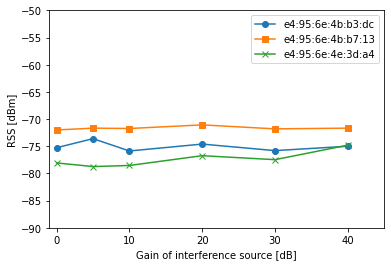

In [43]:
mesh_config_result = "../Mesh Configuration/Interference_1/Dongle/results_"
mesh_config_result_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        mesh_config_result + "5G.txt",
                        mesh_config_result + "10G.txt",
                        mesh_config_result + "20G.txt",
                        mesh_config_result + "30G.txt",
                        mesh_config_result + "40G.txt",
                        ]
plot_rss(mesh_config_result_files,"", [0, 5, 10, 20, 30, 40],x_label='Gain of interference source [dB]',x_limit=(-1, 45))

[-75.26666666666667, -77.53333333333333, -73.46666666666667, -77.26666666666667, -74.6, -76.13333333333334]
[-72.0, -72.0, -70.86666666666666, -71.93333333333334, -71.26666666666667, -71.33333333333333]
[-78.06666666666666, -79.0, -76.33333333333333, -78.06666666666666, -76.26666666666667, -77.66666666666667]


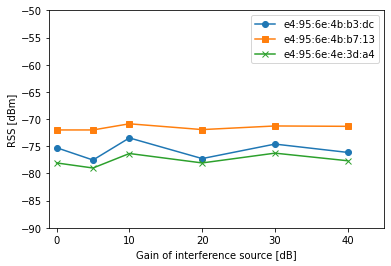

In [44]:
mesh_config_result = "../Mesh Configuration/Interference_2/Dongle/results_"
mesh_config_result_files = ["../Mesh Configuration/No Interference/Dongle/results.txt",
                        mesh_config_result + "5G.txt",
                        mesh_config_result + "10G.txt",
                        mesh_config_result + "20G.txt",
                        mesh_config_result + "30G.txt",
                        mesh_config_result + "40G.txt",
                        ]
plot_rss(mesh_config_result_files,"",[0, 5, 10, 20, 30, 40],x_label='Gain of interference source [dB]',x_limit=(-1, 45))

In [ ]:
import statistics
mesh_config_result = "../Mesh Configuration/Interference_1/Dongle/results_"
mesh_config_result_files = [mesh_config_result + "5G.txt",
                        mesh_config_result + "10G.txt",
                        mesh_config_result + "20G.txt",
                        mesh_config_result + "30G.txt",
                        mesh_config_result + "40G.txt",
                        ]
mesh_config_result_multi_node = "../Mesh Configuration/Interference_2/Dongle/results_"
mesh_config_result_multi_node_files = [mesh_config_result_multi_node + "5G.txt",
                        mesh_config_result_multi_node + "10G.txt",
                        mesh_config_result_multi_node + "20G.txt",
                        mesh_config_result_multi_node + "30G.txt",
                        mesh_config_result_multi_node + "40G.txt",
                        ]
mesh_config_result_0G_file = "../Mesh Configuration/No Interference/Dongle/results.txt"
avg_rtt_0g = converted_ping_data(mesh_config_result_0G_file,"avg_rtt")
boxplot_titles = ['5 dB','10 dB','20 dB','30 dB', '40 dB']

for filename, filename_multi, title in zip(mesh_config_result_files, mesh_config_result_multi_node_files, boxplot_titles):
    avg_rtt = converted_ping_data(filename,"avg_rtt")
    avg_rtt_multi = converted_ping_data(filename_multi,"avg_rtt")
    data_dict = {'No interference': avg_rtt_0g[0],'Single-node': avg_rtt[0], 'Multi-node': avg_rtt_multi[0]}
    fig, ax = plt.subplots()
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_yscale('log')
    ax.set_ylim(1, 2**8)
    ax.set_ylabel('RTT [ms]')
    print(title)
    print('No int: ' + str(statistics.median(avg_rtt_0g[0])))
    print('Single: '+ str(statistics.median(avg_rtt[0])))
    print('Multi: '+ str(statistics.median(avg_rtt_multi[0])))
    
    ax.set_title(title + ' gain on interference source')

In [ ]:
transmission_power_path = "../Transmission Power/Dongle/Single-hop/iperf_results_"
transmission_power_no_int_files = [
                        transmission_power_path + "10TX.txt",
                        transmission_power_path + "11TX.txt",
                        transmission_power_path + "12TX.txt",
                        transmission_power_path + "13TX.txt",
                        transmission_power_path + "14TX.txt",
                        transmission_power_path + "15TX.txt",
                        transmission_power_path + "16TX.txt",
                        transmission_power_path + "17TX.txt",
                        transmission_power_path + "18TX.txt",
                        transmission_power_path + "19TX.txt",
                        transmission_power_path + "20TX.txt",
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Transmission power [dBm]"
title = "No interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
            13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
            17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
            18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
            19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

limits = [(9, 21), (0, 8000000)]


scatter_plot_iperf_bitrate(transmission_power_no_int_files,y_label,x_label,x_axis, title, limits)

In [ ]:
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/iperf_results_"
transmission_power_int_files = [
                        transmission_power_int_path + "10TX.txt",
                        transmission_power_int_path + "12TX.txt",
                        transmission_power_int_path + "14TX.txt",
                        transmission_power_int_path + "16TX.txt",
                        transmission_power_int_path + "18TX.txt",
                        transmission_power_int_path + "20TX.txt",
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Transmission power [dBm]"
title = "With interference"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
            14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
            18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

limits = [(9, 21), (0, 8000000)]


scatter_plot_iperf_bitrate(transmission_power_int_files,y_label,x_label,x_axis, title, limits)

In [ ]:
transmission_power_path = "../Transmission Power/Dongle/Single-hop/results_"
transmission_power_no_int_files = [
                        transmission_power_path + "10TX.txt",
                        transmission_power_path + "11TX.txt",
                        transmission_power_path + "12TX.txt",
                        transmission_power_path + "13TX.txt",
                        transmission_power_path + "14TX.txt",
                        transmission_power_path + "15TX.txt",
                        transmission_power_path + "16TX.txt",
                        transmission_power_path + "17TX.txt",
                        transmission_power_path + "18TX.txt",
                        transmission_power_path + "19TX.txt",
                        transmission_power_path + "20TX.txt",
                        ]
plot_rss(transmission_power_no_int_files,"", [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'TX power on nodes [dBm]')

In [ ]:
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/results_"
transmission_power_int_files = [
                        transmission_power_int_path + "10TX.txt",
                        transmission_power_int_path + "12TX.txt",
                        transmission_power_int_path + "14TX.txt",
                        transmission_power_int_path + "16TX.txt",
                        transmission_power_int_path + "18TX.txt",
                        transmission_power_int_path + "20TX.txt",
                        ]
plot_rss(transmission_power_int_files,"", [10, 12, 14, 16, 18, 20], 'TX power on nodes [dBm]')

In [ ]:
transmission_power_path = "../Transmission Power/Dongle/Single-hop/results_"
transmission_power_no_int_files = [
                        transmission_power_path + "10TX.txt",
                        transmission_power_path + "11TX.txt",
                        transmission_power_path + "12TX.txt",
                        transmission_power_path + "13TX.txt",
                        transmission_power_path + "14TX.txt",
                        transmission_power_path + "15TX.txt",
                        transmission_power_path + "16TX.txt",
                        transmission_power_path + "17TX.txt",
                        transmission_power_path + "18TX.txt",
                        transmission_power_path + "19TX.txt",
                        transmission_power_path + "20TX.txt",
                        ]
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/results_"
transmission_power_int_files = [
                        transmission_power_int_path + "10TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "12TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "14TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "16TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "18TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "20TX.txt",
                        ]

boxplot_titles = ['10 dBm','11 dBm','12 dBm','13 dBm','14 dBm','15 dBm','16 dBm','17 dBm','18 dBm','19 dBm','20 dBm']

for filename, filename_int, title in zip(transmission_power_no_int_files, transmission_power_int_files, boxplot_titles):
    avg_rtt = converted_ping_data(filename,"avg_rtt")
    if 'DOES NOT EXIST' not in filename_int:
        avg_rtt_int = converted_ping_data(filename_int,"avg_rtt")
        data_dict = {'No interference': avg_rtt[0], 'With interference': avg_rtt_int[0]}
        print(title)
        print(str(min(avg_rtt[0])) + ' vs ' + str(max(avg_rtt[0])))
        print(str(min(avg_rtt_int[0])) + ' vs ' + str(max(avg_rtt_int[0])))


    else:
        data_dict = {'No interference': avg_rtt[0]}

    fig, ax = plt.subplots()
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    #ax.set_yscale('log')
    ax.set_ylim(0, 12)
    ax.set_ylabel('RTT [ms]')
    
    ax.set_title(title + ' TX power on nodes')

In [ ]:
transmission_power_path = "../Transmission Power/Dongle/Single-hop/iperf_results_"
transmission_power_no_int_files = [
                        transmission_power_path + "10TX.txt",
                        transmission_power_path + "11TX.txt",
                        transmission_power_path + "12TX.txt",
                        transmission_power_path + "13TX.txt",
                        transmission_power_path + "14TX.txt",
                        transmission_power_path + "15TX.txt",
                        transmission_power_path + "16TX.txt",
                        transmission_power_path + "17TX.txt",
                        transmission_power_path + "18TX.txt",
                        transmission_power_path + "19TX.txt",
                        transmission_power_path + "20TX.txt",
                        ]
transmission_power_int_path = "../Transmission Power/Dongle/Single-hop_interference/iperf_results_"
transmission_power_int_files = [
                        transmission_power_int_path + "10TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "12TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "14TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "16TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "18TX.txt",
                        'DOES NOT EXIST',
                        transmission_power_int_path + "20TX.txt",
                        ]
                        # 90m & 100m does not exist because it was not possible to create a connection during interference
boxplot_titles = ['10 dBm','11 dBm','12 dBm','13 dBm','14 dBm','15 dBm','16 dBm','17 dBm','18 dBm','19 dBm','20 dBm']

for filename, filename_interference, title in zip(transmission_power_no_int_files, transmission_power_int_files, boxplot_titles):
    client_data, server_data = prepare_boxplot_data(filename)
    
    if 'DOES NOT EXIST' not in filename_interference:
        client_interference_data, server_interference_data = prepare_boxplot_data(filename_interference)
        data_dict = {'Client': client_data, 'Client w. interference': client_interference_data,
                    'Server': server_data, 'Server w. interference': server_interference_data}    
    else:
        data_dict = {'Client': client_data,
                    'Server': server_data}
    
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 9000000)
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [bits/sec]')
    ax.set_title(title + ' TX power')

In [ ]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
############################# CONTROL EXPERIMENT - MULTI-NODE INTERFERENCE #############################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
control_interference_file_iperf = "../Mesh Configuration V2/Interference_2/iperf_results_"
control_interference_iperf_files = ["../Mesh Configuration V2/No Interference/iperf_results_1.txt",
                        control_interference_file_iperf + "5G.txt",
                        control_interference_file_iperf + "10G.txt",
                        control_interference_file_iperf + "20G.txt",
                        control_interference_file_iperf + "30G.txt",
                        control_interference_file_iperf + "40G.txt",
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Gain of interference source [dB]"
title = "Multi-node interference"
x_axis = [  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

limits = [(-5, 45), (0, 2000000)]


scatter_plot_iperf_bitrate(control_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
control_single_interference_file_iperf = "../Mesh Configuration V2/Interference_1/iperf_results_"
control_single_interference_iperf_files = ["../Mesh Configuration V2/No Interference/iperf_results_2.txt",
                        control_single_interference_file_iperf + "5G.txt",
                        control_single_interference_file_iperf + "10G.txt",
                        control_single_interference_file_iperf + "20G.txt",
                        control_single_interference_file_iperf + "30G.txt",
                        control_single_interference_file_iperf + "40G.txt",
                        ]

y_label = "Throughput [bits/sec]"
x_label = "Gain of interference source [dB]"
title = "Single-node interference"
x_axis = [  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

limits = [(-5, 45), (0, 2000000)]


scatter_plot_iperf_bitrate(control_single_interference_iperf_files,y_label,x_label,x_axis, title, limits)

In [ ]:
import statistics
control_single_path = "../Mesh Configuration V2/Interference_1/iperf_results_"
control_single_int_files = [
                        "../Mesh Configuration V2/No Interference/iperf_results_1.txt",
                        control_single_path + "5G.txt",
                        control_single_path + "10G.txt",
                        control_single_path + "20G.txt",
                        control_single_path + "30G.txt",
                        control_single_path + "40G.txt",
                        ]
control_multi_int_path = "../Mesh Configuration V2/Interference_2/iperf_results_"
control_multi_int_files = [
                        "../Mesh Configuration V2/No Interference/iperf_results_2.txt",
                        control_multi_int_path + "5G.txt",
                        control_multi_int_path + "10G.txt",
                        control_multi_int_path + "20G.txt",
                        control_multi_int_path + "30G.txt",
                        control_multi_int_path + "40G.txt",
                        ]
                        # 90m & 100m does not exist because it was not possible to create a connection during interference
boxplot_titles = ['NO INTERFERENCE', '5 dB','10 dB','20 dB','30 dB', '40 dB']

for filename_single, filename_multi, title in zip(control_single_int_files, control_multi_int_files, boxplot_titles):
    client_data_single, server_data_single = prepare_boxplot_data(filename_single)
    
    client_data_multi, server_data_multi = prepare_boxplot_data(filename_multi)
    data_dict = {'Client (S)': client_data_single, 'Client (M)': client_data_multi,
                'Server (S)': server_data_single, 'Server (M)': server_data_multi}    
    
    fig, ax = plt.subplots()
    ax.set_ylim(-500000, 6000000)
    print(str(statistics.median(client_data_single)) + '\t' + str(statistics.median(client_data_multi)) + '\t' + str(statistics.median(server_data_single)) + '\t' +str(statistics.median(server_data_multi)))
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_ylabel('Throughput [bits/sec]')
    if 'NO INTERFERENCE' in title:
        ax.set_title("No interference")
    else:
        ax.set_title(title + ' gain')

In [ ]:
median_dict = {#'Client (S)': [927000.0, 927000.0, 927000.0, 927000.0, 927000.0, 927000.0],
                #'Client (M)': [927000.0, 927000.0, 927000.0, 927000.0, 927000.0, 927000.0],
                'Server (S)': [545000.0, 214500.0, 446000.0, 388000.0, 452000.0, 359000.0],
                'Server (M)': [475000.0, 405000.0, 394000.0, 255000.0, 336000.0, 313000.0]}
x_axis = [0,5,10,20,30,40]
fig, ax = plt.subplots()
#ax.set_ylim(-500000, 6000000)
# ax.plot(x_axis, median_dict['Client (S)'])
# ax.plot(x_axis, median_dict['Client (M)'])
ax.scatter(x_axis, median_dict['Server (S)'])
ax.scatter(x_axis, median_dict['Server (M)'])
ax.set_ylabel('Throughput [bits/sec]')
ax.set_ylim(0, 600000)
z_s = np.polyfit(x_axis, median_dict['Server (S)'], 1)
z_m = np.polyfit(x_axis, median_dict['Server (M)'], 1)
p_s = np.poly1d(z_s)
p_m = np.poly1d(z_m)
ax.plot(x_axis, p_s(x_axis), linestyle='--')
ax.plot(x_axis, p_m(x_axis), linestyle='--')
ax.legend(['Server (S)', 'Server (M)'])


In [ ]:
import statistics
control_single_int_result = "../Mesh Configuration V2/Interference_1/results_"
control_single_int_result_files = [
                        control_single_int_result + "5G.txt",
                        control_single_int_result + "10G.txt",
                        control_single_int_result + "20G.txt",
                        control_single_int_result + "30G.txt",
                        control_single_int_result + "40G.txt",
                        ]
control_result_multi_node = "../Mesh Configuration V2/Interference_2/results_"
control_result_multi_node_files = [
                        control_result_multi_node + "5G.txt",
                        control_result_multi_node + "10G.txt",
                        control_result_multi_node + "20G.txt",
                        control_result_multi_node + "30G.txt",
                        control_result_multi_node + "40G.txt",
                        ]

control_result_0G_file_1 = "../Mesh Configuration V2/No Interference/results_1.txt"
control_result_0G_file_2 = "../Mesh Configuration V2/No Interference/results_2.txt"

avg_rtt_0g_1 = converted_ping_data(control_result_0G_file_1,"avg_rtt")
avg_rtt_0g_2 = converted_ping_data(control_result_0G_file_2,"avg_rtt")

boxplot_titles = ['5 dB','10 dB','20 dB','30 dB', '40 dB']

for filename_single, filename_multi, title in zip(control_single_int_result_files, control_result_multi_node_files, boxplot_titles):
    avg_rtt_single = converted_ping_data(filename_single, "avg_rtt")
    avg_rtt_multi = converted_ping_data(filename_multi,"avg_rtt")
    avg_rtt_multi_result = []
    for result in avg_rtt_multi[0]: # Remove nan
        if result == result:
            avg_rtt_multi_result.append(result)

    data_dict = {'No int. (S)': avg_rtt_0g_1[0], 'Single-node':avg_rtt_single[0],
                'No int. (M)': avg_rtt_0g_2[0], 'Multi-node': avg_rtt_multi_result}
    fig, ax = plt.subplots()
    ax.boxplot(data_dict.values())
    ax.set_xticklabels(data_dict.keys())
    ax.set_yscale('log')
    #ax.set_ylim(0, 150)
    print(str(statistics.median(avg_rtt_0g_1[0])) + '\t' + str(statistics.median(avg_rtt_single[0])) + '\t' + str(statistics.median(avg_rtt_0g_2[0])) + '\t' + str(statistics.median(avg_rtt_multi_result)))
    ax.set_ylabel('RTT [ms]')
    
    if 'NO INTERFERENCE' in title:
        ax.set_title('No interference')
    else:
        ax.set_title(title + ' gain')

In [ ]:
median_dict = { 'No int (S)': [14.87, 14.87, 14.87, 14.87, 14.87],
                'No int (M)': [20.967, 20.967, 20.967, 20.967, 20.967],
                'Single-node': [59.106, 51.158, 38.744, 14.681, 14.715],
                'Multi-node': [205.97199999999998, 47.187, 21.856, 15.225, 18.792]}
x_axis = [5,10,20,30,40]
fig, ax = plt.subplots()
#ax.set_ylim(-500000, 6000000)
# ax.plot(x_axis, median_dict['Client (S)'])
# ax.plot(x_axis, median_dict['Client (M)'])
ax.scatter(x_axis, median_dict['Single-node'], marker='o')
ax.scatter(x_axis, median_dict['Multi-node'], marker='s')

ax.set_ylabel('Median RTT [ms]')
ax.set_ylim(-15, 220)
z_s = np.polyfit(x_axis, median_dict['Single-node'], 1)
z_m = np.polyfit(x_axis, median_dict['Multi-node'], 2)
z_s_no_int = np.polyfit(x_axis, median_dict['No int (S)'], 1)
z_m_no_int = np.polyfit(x_axis, median_dict['No int (M)'], 1)

p_s = np.poly1d(z_s)
p_m = np.poly1d(z_m)
p_s_no_int = np.poly1d(z_s_no_int)
p_m_no_int = np.poly1d(z_m_no_int)

ax.plot(x_axis, p_s(x_axis), linestyle='--')
ax.plot(x_axis, p_m(x_axis), linestyle='--')
ax.plot(x_axis, p_s_no_int(x_axis), alpha=0.7)
ax.plot(x_axis, p_m_no_int(x_axis), alpha=0.7)

ax.legend(['Single-node', 'Multi-node', 'No int (S)', 'No int (M)'])

In [5]:
import numpy as np

def extract_route_entries(input_list):
    result = []
    
    for i in range(2, len(input_list), 4):
        result.append(input_list[i])
    
    return result

def find_metric_and_percentage_of_relay(mac_address, words):
    relay_metric_number = np.nan
    index_of_relay_metric = 0
    for index, word in enumerate(words):
        if( word == "relay" and words[index+1] == mac_address):
            relay_metric_number = words[index+3]
            index_of_relay_metric = index
            break

    relay_p_index = words.index("p:", index_of_relay_metric)
    relay_percentage = words[relay_p_index + 1]

    return (relay_metric_number, relay_percentage)

def extract_metric_info(input_string, extra_node=False, tx_pow_experiment=False):
    words = input_string.split()
    metric_index = words.index("metric")
    metric_number = words[metric_index + 1]
    p_index = words.index("p:")
    percentage = words[p_index + 1]
    modulation = words[words.index("rate:")+1]
    
    dest_a4_metric_number, dest_a4_percentage = find_metric_and_percentage_of_relay("e4:95:6e:4e:3d:a4", words)
    if not tx_pow_experiment:
        relay_dc_metric_number, relay_dc_percentage = find_metric_and_percentage_of_relay("e4:95:6e:4b:b3:dc", words)
        if extra_node:
            relay_13_metric_number, relay_13_percentage = find_metric_and_percentage_of_relay("e4:95:6e:4b:b7:13", words)
            return(metric_number, percentage, dest_a4_metric_number, dest_a4_percentage, relay_dc_metric_number, relay_dc_percentage, modulation, relay_13_metric_number, relay_13_percentage)
        
        return (metric_number, percentage, dest_a4_metric_number, dest_a4_percentage, relay_dc_metric_number, relay_dc_percentage, modulation)
    return(metric_number, percentage, dest_a4_metric_number, dest_a4_percentage, modulation)


In [67]:

files = ["../Distance/Dongle/Multi-hop/results_10m.txt",
    "../Distance/Dongle/Multi-hop/results_20m.txt",
    "../Distance/Dongle/Multi-hop/results_30m.txt",
    "../Distance/Dongle/Multi-hop/results_40m.txt",
    "../Distance/Dongle/Multi-hop/results_50m.txt",
    "../Distance/Dongle/Multi-hop/results_60m.txt",
    "../Distance/Dongle/Multi-hop/results_70m.txt",
    "../Distance/Dongle/Multi-hop/results_80m.txt",
    "../Distance/Dongle/Multi-hop/results_90m.txt",
    "../Distance/Dongle/Multi-hop/results_100m.txt"]
distances = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
distance_index = 0

for file in files:
    filetext = read_file(file)
    line_text = filetext.split("\n")
    line_text_2 = remove_separations(line_text)
    route_entries = extract_route_entries(line_text_2)
    for entry in route_entries:
        route_info = extract_metric_info(entry)
        test = str(distances[distance_index])
        for tuple_entry in route_info:
            test = test+"," + tuple_entry
        f = open("multihop_no_int_route.txt", "a")
        f.write(test+"\n")
        f.close()
    distance_index = distance_index + 1



In [68]:

files_int = ["../Distance/Dongle/Multi-hop_interference/results_10m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_20m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_30m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_40m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_50m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_60m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_70m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_80m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_90m.txt",
    "../Distance/Dongle/Multi-hop_interference/results_100m.txt"]
distances = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
distance_index = 0

for file in files_int:
    filetext = read_file(file)
    line_text = filetext.split("\n")
    line_text_2 = remove_separations(line_text)
    route_entries = extract_route_entries(line_text_2)
    for entry in route_entries:
        route_info = extract_metric_info(entry)
        test = str(distances[distance_index])
        for tuple_entry in route_info:
            test = test+"," + tuple_entry
        f = open("multihop_int_route.txt", "a")
        f.write(test+"\n")
        f.close()
    distance_index = distance_index + 1



In [69]:

mesh_files_single = ["../Mesh Configuration/Interference_1/Dongle/results_5G.txt",
    "../Mesh Configuration/Interference_1/Dongle/results_10G.txt",
    "../Mesh Configuration/Interference_1/Dongle/results_20G.txt",
    "../Mesh Configuration/Interference_1/Dongle/results_30G.txt",
    "../Mesh Configuration/Interference_1/Dongle/results_40G.txt"]
gain = [5, 10, 20, 30, 40]
gain_index = 0

for file in mesh_files_single:
    filetext = read_file(file)
    line_text = filetext.split("\n")
    line_text_2 = remove_separations(line_text)
    route_entries = extract_route_entries(line_text_2)
    for entry in route_entries:
        route_info = extract_metric_info(entry, True)
        test = str(gain[gain_index])
        for tuple_entry in route_info:
            test = test+"," + tuple_entry
        f = open("mesh_single_int_route.txt", "a")
        f.write(test+"\n")
        f.close()
    gain_index = gain_index + 1



In [ ]:

mesh_files_multi = ["../Mesh Configuration/Interference_2/Dongle/results_5G.txt",
    "../Mesh Configuration/Interference_2/Dongle/results_10G.txt",
    "../Mesh Configuration/Interference_2/Dongle/results_20G.txt",
    "../Mesh Configuration/Interference_2/Dongle/results_30G.txt",
    "../Mesh Configuration/Interference_2/Dongle/results_40G.txt"]
gain = [5, 10, 20, 30, 40]
gain_index = 0

for file in mesh_files_multi:
    filetext = read_file(file)
    line_text = filetext.split("\n")
    line_text_2 = remove_separations(line_text)
    route_entries = extract_route_entries(line_text_2)
    for entry in route_entries:
        route_info = extract_metric_info(entry, True)
        test = str(gain[gain_index])
        for tuple_entry in route_info:
            test = test+"," + tuple_entry
        f = open("mesh_multi_int_route.txt", "a")
        f.write(test+"\n")
        f.close()
    gain_index = gain_index + 1



In [10]:

mesh_v2_files_single = ["../Mesh Configuration V2/Interference_1/results_5G.txt",
    "../Mesh Configuration V2/Interference_1/results_10G.txt",
    "../Mesh Configuration V2/Interference_1/results_20G.txt",
    "../Mesh Configuration V2/Interference_1/results_30G.txt",
    "../Mesh Configuration V2/Interference_1/results_40G.txt"]
gain = [5, 10, 20, 30, 40]
gain_index = 0

for file in mesh_v2_files_single:
    filetext = read_file(file)
    line_text = filetext.split("\n")
    line_text_2 = remove_separations(line_text)
    route_entries = extract_route_entries(line_text_2)
    for entry in route_entries:
        route_info = extract_metric_info(entry, True)
        test = str(gain[gain_index])
        for tuple_entry in route_info:
            test = test+"," + tuple_entry
        f = open("mesh_v2_single_int_route.txt", "a")
        f.write(test+"\n")
        f.close()
    gain_index = gain_index + 1
 


In [ ]:

mesh_v2_files_multi = ["../Mesh Configuration V2/Interference_2/results_5G.txt",
    "../Mesh Configuration V2/Interference_2/results_10G.txt",
    "../Mesh Configuration V2/Interference_2/results_20G.txt",
    "../Mesh Configuration V2/Interference_2/results_30G.txt",
    "../Mesh Configuration V2/Interference_2/results_40G.txt"]
gain = [5, 10, 20, 30, 40]
gain_index = 0

for file in mesh_v2_files_multi:
    filetext = read_file(file)
    line_text = filetext.split("\n")
    line_text_2 = remove_separations(line_text)
    route_entries = extract_route_entries(line_text_2)
    for entry in route_entries:
        route_info = extract_metric_info(entry, True)
        test = str(gain[gain_index])
        for tuple_entry in route_info:
            test = test+"," + tuple_entry
        f = open("mesh_v2_multi_int_route.txt", "a")
        f.write(test+"\n")
        f.close()
    gain_index = gain_index + 1

[-69.73333333333333, -72.06666666666666, -73.13333333333334, -71.26666666666667, -71.2, -71.53333333333333]
[-73.26666666666667, -70.93333333333334, -69.33333333333333, -72.53333333333333, -69.13333333333334, -69.26666666666667]
[-78.66666666666667, -80.26666666666667, -80.93333333333334, -79.73333333333333, -80.26666666666667, -77.53333333333333]


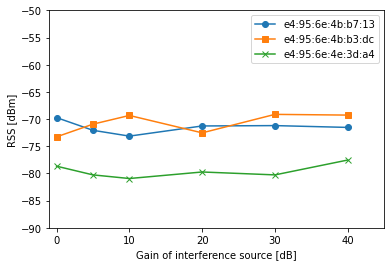

In [45]:
mesh_v2_files_multi = ["../Mesh Configuration V2/No Interference/results_1.txt",
    "../Mesh Configuration V2/Interference_1/results_5G.txt",
    "../Mesh Configuration V2/Interference_1/results_10G.txt",
    "../Mesh Configuration V2/Interference_1/results_20G.txt",
    "../Mesh Configuration V2/Interference_1/results_30G.txt",
    "../Mesh Configuration V2/Interference_1/results_40G.txt"]
    
plot_rss(mesh_v2_files_multi,"", [0, 5, 10, 20, 30, 40],x_label='Gain of interference source [dB]',x_limit=(-1, 45))

[-70.26666666666667, -69.46666666666667, -70.53333333333333, -69.6, -69.46666666666667, -68.66666666666667]
[-79.2, -81.0, -79.33333333333333, -80.46666666666667, -79.73333333333333, -80.2]
[-70.53333333333333, -77.06666666666666, -71.93333333333334, -74.73333333333333, -71.46666666666667, -73.06666666666666]


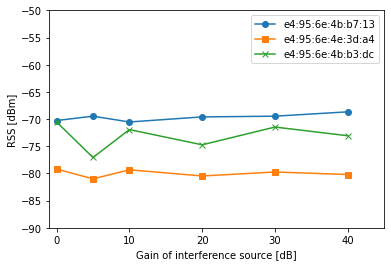

In [46]:

mesh_v2_files_multi = ["../Mesh Configuration V2/No Interference/results_2.txt",
    "../Mesh Configuration V2/Interference_2/results_5G.txt",
    "../Mesh Configuration V2/Interference_2/results_10G.txt",
    "../Mesh Configuration V2/Interference_2/results_20G.txt",
    "../Mesh Configuration V2/Interference_2/results_30G.txt",
    "../Mesh Configuration V2/Interference_2/results_40G.txt"]
    
plot_rss(mesh_v2_files_multi,"", [0, 5, 10, 20, 30, 40],x_label='Gain of interference source [dB]',x_limit=(-1, 45))

In [8]:
transmission_power_files_int = ["../Transmission Power/Dongle/Single-hop_interference/results_10TX.txt",
                            "DOES NOT EXIST",
                            "../Transmission Power/Dongle/Single-hop_interference/results_12TX.txt",
                            "DOES NOT EXIST",
                            "../Transmission Power/Dongle/Single-hop_interference/results_14TX.txt",
                            "DOES NOT EXIST",
                            "../Transmission Power/Dongle/Single-hop_interference/results_16TX.txt",
                            "DOES NOT EXIST",
                            "../Transmission Power/Dongle/Single-hop_interference/results_18TX.txt",
                            "DOES NOT EXIST",
                            "../Transmission Power/Dongle/Single-hop_interference/results_20TX.txt",]
transmission_power_files = ["../Transmission Power/Dongle/Single-hop/results_10TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_11TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_12TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_13TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_14TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_15TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_16TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_17TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_18TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_19TX.txt",
                            "../Transmission Power/Dongle/Single-hop/results_20TX.txt",]
tx_power = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
tx_power_index = 0

for file, file_int in zip(transmission_power_files, transmission_power_files_int):
    if(tx_power[tx_power_index]%2 == 0):
        filetext_int = read_file(file_int)
        line_text_int = filetext_int.split("\n")
        line_text_2_int = remove_separations(line_text_int)
        route_entries_int = extract_route_entries(line_text_2_int)

        filetext = read_file(file)
        line_text = filetext.split("\n")
        line_text_2 = remove_separations(line_text)
        route_entries = extract_route_entries(line_text_2)
        for entry, entry_int in zip(route_entries, route_entries_int):
            route_info = extract_metric_info(entry, tx_pow_experiment=True)
            route_info_int = extract_metric_info(entry_int, tx_pow_experiment=True)
            test = str(tx_power[tx_power_index])
            for tuple_entry in route_info:
                test = test + "," + tuple_entry
            for tuple_entry_int in route_info_int:
                test = test + "," + tuple_entry_int
            f = open("tx_power_int_route_both.txt", "a")
            f.write(test+"\n")
            f.close()
    else:
        filetext = read_file(file)
        line_text = filetext.split("\n")
        line_text_2 = remove_separations(line_text)
        route_entries = extract_route_entries(line_text_2)
        for entry in route_entries:
            route_info = extract_metric_info(entry, tx_pow_experiment=True)
            test = str(tx_power[tx_power_index])
            for tuple_entry in route_info:
                test = test + "," + tuple_entry
            f = open("tx_power_int_route.txt", "a")
            f.write(test+"\n")
            f.close()
    tx_power_index = tx_power_index + 1
